## Task 2 Plan

Station Analysis Plan
* **Accessibility**: Evaluate how well the bike-sharing stations are distributed across the network
  * Metrics: 1) station level average distance to Nearest Neighbours (Geo)
* **Utilisation efficiency**: whether each station has adequate number of bikes
  * Metrics: station level 1) Station Balance: The ratio of incoming to outgoing tripss


## 2.1 Accessibility

In [3]:
import os
import pandas as pd
import numpy as np
import random
import igraph as ig

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.neighbors import NearestNeighbors

import networkx as nx
import scipy
import scipy.sparse

seed = 2024

In [4]:
stations_geo_df = pd.read_csv("processed_data/stations_geo.csv")
undirectional_edges_df = pd.read_csv("processed_data/total_edge_undirectional.csv")

In [5]:
def analyze_and_plot(data, edge_data, title_suffix, weight_param = 1, draw_distribution = False):
    X = data[['lat', 'lng']].values

    # Nearest neighbour
    n = 11
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    average_distances = distances[:, 1:].mean(axis=1)
    data['average_nearest_neighbor_distance'] = average_distances

    # Draw distribution
    if draw_distribution is True:
        mean_distance = np.mean(average_distances)
        
        plt.figure(figsize=(10, 6))
        plt.hist(average_distances, bins=50, alpha=0.75, density=True)
        plt.axvline(mean_distance, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f}')
        plt.xlabel(f'Geographic Distance to Nearest Neighbor {title_suffix}')
        plt.ylabel('Density')
        plt.title('Distribution of Distance to 10 Nearest Neighbours for Each Station')
        plt.legend()
        plt.show()

    # Get top 10 percent furthest nodes
    sorted_stations = data.sort_values(by='average_nearest_neighbor_distance', ascending=False)
    top_10_percent_cutoff = int(len(sorted_stations) * 0.1)
    top_10_percent_stations = sorted_stations.head(top_10_percent_cutoff)
    top_10_percent_stations_df = top_10_percent_stations[['station_id', 'average_nearest_neighbor_distance']]

    # Map the nodes based on geo location
    
    nodes = data.set_index('station_id').to_dict('index')
    G = nx.Graph()
    for node, attrs in nodes.items():
        G.add_node(node, **attrs)
    
    # Add edges with weights to the graph
    edges = edge_data[['min_station_id', 'max_station_id', 'trip_count']]
    G.add_weighted_edges_from(edges.values)
    
    # Calculate node degrees for sizing (no need to set node attributes)
    degrees = dict(G.degree())
    max_degree = max(degrees.values(), default=1)
    node_sizes = [degrees.get(node, 0) * 200 / max_degree for node in G.nodes()]
    
    degree_threshold = max_degree * 0.9
    
    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, 'weight').values()
    max_weight = max(weights, default=1)
    weights_normalized = [weight * weight_param / max_weight for weight in weights]
    
    # Get positions from node attributes
    pos = {node: (data['lng'], data['lat']) for node, data in G.nodes(data=True)}
    
    # Prepare node colors - default color for most nodes, red for top 10%
    node_colors = ['red' if node in top_10_percent_stations_df['station_id'].to_list() else 'lightgrey' for node in list(G.nodes())]
    red_patch = mpatches.Patch(color='red', label='Top 10% Furthest Stations')
    blue_patch = mpatches.Patch(color='deepskyblue', label='Other Stations')
    
    # Draw the network with improved visual parameters
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.7)
    plt.title(f'Network Graph Based on Geographical Locations {title_suffix}')
    plt.legend(handles=[red_patch, blue_patch], loc='upper right')
    plt.axis('off')
    plt.show()

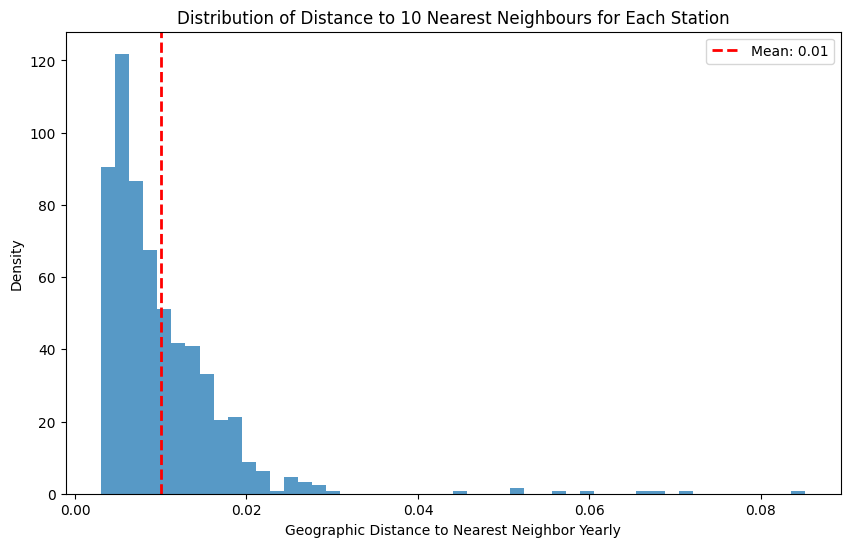

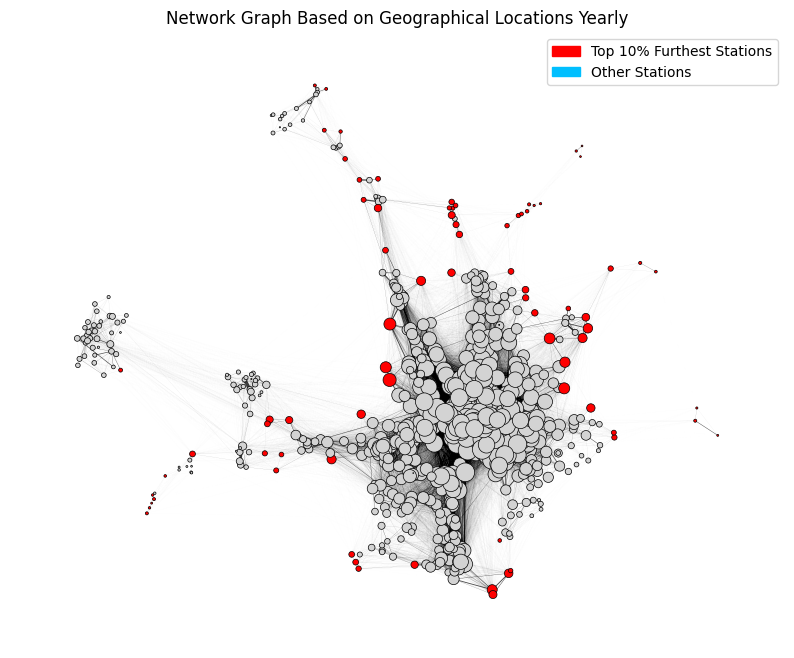

In [7]:
data = stations_geo_df.copy()
edge_data = undirectional_edges_df.copy()
title_suffix = 'Yearly'
weight_param = 10
draw_distribution = True

analyze_and_plot(data, edge_data, title_suffix = title_suffix, weight_param = weight_param, draw_distribution = draw_distribution)

# 2.2 Utilisation efficiency

In [8]:
edge_df = pd.read_csv("processed_data/edge_file.csv")
edge_df

,Unnamed: 0,year,month,start_station_id,end_station_id,rideable_type,member_casual,trip_count
0,0,2023,1,31000.0,31000.0,classic_bike,casual,3
1,1,2023,1,31000.0,31000.0,classic_bike,member,5
2,2,2023,1,31000.0,31000.0,docked_bike,casual,2
3,3,2023,1,31000.0,31000.0,electric_bike,casual,1
4,4,2023,1,31000.0,31002.0,classic_bike,member,2
...,...,...,...,...,...,...,...,...
1377142,1377142,2024,1,33200.0,31940.0,classic_bike,member,1
1377143,1377143,2024,1,33200.0,31959.0,electric_bike,casual,1
1377144,1377144,2024,1,33200.0,33200.0,classic_bike,casual,10
1377145,1377145,2024,1,33200.0,33200.0,classic_bike,member,1


In [10]:
# Quarterly data
edge_df['quarter'] = pd.to_datetime(edge_df['month'], format='%m').dt.to_period('Q').dt.quarter
incoming_trips_q = edge_df.groupby(['end_station_id', 'year', 'quarter']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'incoming_trips', 'end_station_id': 'station_id'})
outgoing_trips_q = edge_df.groupby(['start_station_id', 'year', 'quarter']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'outgoing_trips', 'start_station_id': 'station_id'})
merged_trips_q = pd.merge(incoming_trips_q, outgoing_trips_q, on=['station_id', 'year', 'quarter'], how='outer')
merged_trips_q['trip_ratio'] = merged_trips_q['incoming_trips'] / merged_trips_q['outgoing_trips']

# Yearly data
incoming_trips = edge_df.groupby(['end_station_id']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'incoming_trips', 'end_station_id': 'station_id'})
outgoing_trips = edge_df.groupby(['start_station_id']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'outgoing_trips', 'start_station_id': 'station_id'})
merged_trips = pd.merge(incoming_trips, outgoing_trips, on=['station_id'], how='outer')
merged_trips['trip_ratio'] = merged_trips['incoming_trips'] / merged_trips['outgoing_trips']

# Merge with geo
merged_trips_q = pd.merge(merged_trips_q, stations_geo_df, how='inner', on='station_id')
merged_trips = pd.merge(merged_trips, stations_geo_df, how='inner', on='station_id')


In [11]:
merged_trips

,station_id,incoming_trips,outgoing_trips,trip_ratio,lat,lng
0,30200.0,13654,10285.0,1.327564,38.894273,-77.024041
1,30201.0,12236,11002.0,1.112161,38.898097,-77.023924
2,31000.0,4151,4118.0,1.008014,38.858971,-77.053230
3,31002.0,4693,4690.0,1.000640,38.856425,-77.049232
4,31003.0,5176,4973.0,1.040820,38.861056,-77.049417
...,...,...,...,...,...,...
768,32609.0,692,704.0,0.982955,38.885621,-77.166917
769,32900.0,1,NaN,NaN,38.964406,-77.010759
770,32901.0,217,129.0,1.682171,38.963810,-77.010266
771,32909.0,1,NaN,NaN,38.964459,-77.010759


In [12]:
merged_trips_q

,station_id,year,quarter,incoming_trips,outgoing_trips,trip_ratio,lat,lng
0,30200.0,2023,1,1411.0,1026.0,1.375244,38.894273,-77.024041
1,30200.0,2023,2,3964.0,3131.0,1.266049,38.894273,-77.024041
2,30200.0,2023,3,4111.0,3120.0,1.317628,38.894273,-77.024041
3,30200.0,2023,4,3546.0,2539.0,1.396613,38.894273,-77.024041
4,30200.0,2024,1,622.0,469.0,1.326226,38.894273,-77.024041
...,...,...,...,...,...,...,...,...
3723,33200.0,2023,1,431.0,357.0,1.207283,38.896604,-77.039778
3724,33200.0,2023,2,1741.0,1733.0,1.004616,38.896604,-77.039778
3725,33200.0,2023,3,1750.0,1677.0,1.043530,38.896604,-77.039778
3726,33200.0,2023,4,1286.0,1261.0,1.019826,38.896604,-77.039778


In [13]:
def analyze_and_plot2(data, edge_data, title_suffix, weight_param = weight_param, plot_options={'incoming': True, 'outgoing': True, 'ratio': True}):
    # Histogram
    plt.figure(figsize=(10, 8))
    plot_count = 1

    if plot_options.get('incoming'):
        # Incoming Trips
        mean_income = np.mean(data['incoming_trips'].dropna())
        plt.subplot(2, 2, plot_count)
        plt.hist(data['incoming_trips'].dropna(), bins=30, alpha=0.7, color='red')
        plt.title(f'Total Incoming Trips {title_suffix}')
        plt.xlabel('Number of Incoming Trips')
        plt.ylabel('Frequency')
        plt.axvline(mean_income, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_income:.2f}')
        plt.legend()
        plot_count += 1

    if plot_options.get('outgoing'):
        # Outgoing Trips
        mean_outgoing = np.mean(data['outgoing_trips'].dropna())
        plt.subplot(2, 2, plot_count)
        plt.hist(data['outgoing_trips'].dropna(), bins=30, alpha=0.7, color='deepskyblue')
        plt.title(f'Total Outgoing Trips {title_suffix}')
        plt.xlabel('Number of Outgoing Trips')
        plt.ylabel('Frequency')
        plt.axvline(mean_outgoing, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_outgoing:.2f}')
        plt.legend()
        plot_count += 1

    if plot_options.get('ratio'):
        # Trip Ratio
        mean_ratio = np.mean(data['trip_ratio'].dropna())
        if plot_count <= 2:
            plt.subplot(2, 2, plot_count)
        else:
            plt.subplot(2, 1, 2)
        plt.hist(data['trip_ratio'].dropna(), bins=30, alpha=0.7, color='green')
        plt.title(f'Trip Ratio {title_suffix}')
        plt.xlabel('Trip Ratio')
        plt.ylabel('Frequency')
        plt.axvline(mean_ratio, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_ratio:.2f}')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Calculate the top 10 and bottom 10 percent trip ratio
    sorted_trips_des = data.dropna().sort_values(by='trip_ratio', ascending=False)
    sorted_trips_asc = data.dropna().sort_values(by='trip_ratio', ascending=True)

    top_10_percent_cutoff = int(len(sorted_trips_des) * 0.1)
    bottom_10_percent_cutoff = int(len(sorted_trips_asc) * 0.1)
    
    top_10_percent_df = sorted_trips_des.head(top_10_percent_cutoff)
    bottom_10_percent_df = sorted_trips_asc.head(bottom_10_percent_cutoff)

    # Draw on map
    nodes = data.set_index('station_id').to_dict('index')
    G = nx.Graph()
    for node, attrs in nodes.items():
        G.add_node(node, **attrs)
    
    # Add edges with weights to the graph
    edges = edge_data[['min_station_id', 'max_station_id', 'trip_count']]
    G.add_weighted_edges_from(edges.values)
    
    # Calculate node degrees for sizing (no need to set node attributes)
    degrees = dict(G.degree())
    max_degree = max(degrees.values(), default=1)
    node_sizes = [degrees.get(node, 0) * 200 / max_degree for node in G.nodes()]
    
    degree_threshold = max_degree * 0.9
    
    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, 'weight').values()
    max_weight = max(weights, default=1)
    weights_normalized = [weight * 10 / max_weight for weight in weights]
    
    # Get positions from node attributes
    pos = {node: (data['lng'], data['lat']) for node, data in G.nodes(data=True)}
    
    # Prepare node colors - default color for most nodes, red for top 10%
    node_colors = ['red' if node in top_10_percent_df['station_id'].to_list() else 'deepskyblue' if node in bottom_10_percent_df['station_id'].to_list() else 'lightgrey' for node in list(G.nodes())]
    red_patch = mpatches.Patch(color='red', label='Top 10% Most Imbalanced Stations in Incoming Bikes')
    blue_patch = mpatches.Patch(color='deepskyblue', label='Top 10% Most Imbalanced Stations in Outgoing Bikes')
    grey_patch = mpatches.Patch(color='lightgrey', label='Other Stations')
    
    # Draw the network with improved visual parameters
    plt.figure(figsize=(15, 12))
    ax = plt.gca()
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.7)
    plt.title(f'Network Graph Based on Geographical Locations {title_suffix}')
    plt.legend(handles=[red_patch, blue_patch, grey_patch], loc='upper right')
    plt.axis('off')
    plt.show()

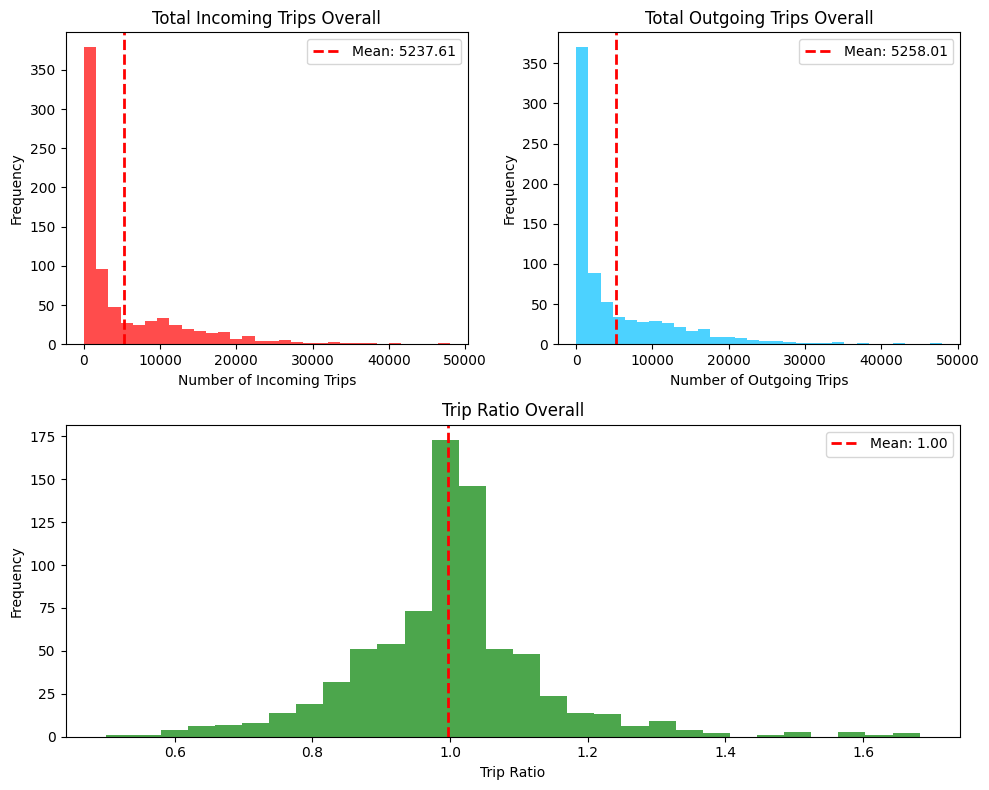

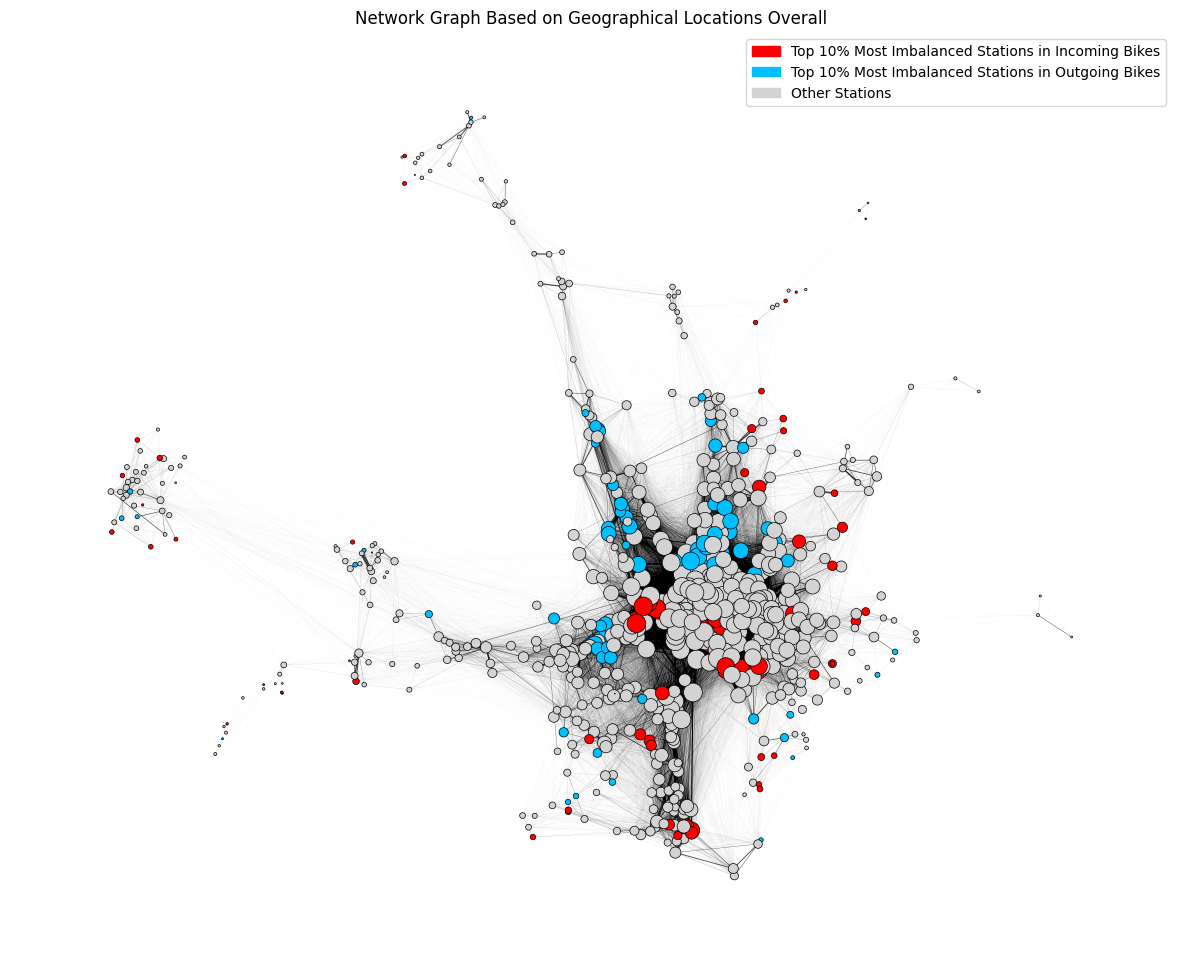

In [15]:
data = merged_trips.copy()
edge_data = undirectional_edges_df.copy()
title_suffix = 'Overall'
weight_param = 10

analyze_and_plot2(data, edge_data, title_suffix = title_suffix, weight_param = weight_param)

# Quarterly Analysis

In [ ]:
# Quarterly node